<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/01_classifying_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classifying Images

Let’s classify images! Although the data is
different, it is still a classification problem, so we will try to predict which class an
image belongs to.

First, let’s generate some images to work with (so we don’t have to use MNIST!).

##Setup

In [ ]:
try:
  import google.colab
  import requests
  url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
  r = requests.get(url, allow_redirects=True)
  open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
  pass

from config import *
config_chapter4()
# This is needed to render the plots in this chapter
from plots.chapter4 import *

In [56]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep
from plots.chapter4 import *

In [57]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Data Generation

Our images are quite simple: They have black backgrounds and white lines drawn
on top of them. The lines can be drawn either in a diagonal or in a parallel way. 

So, our classification
problem can be simply stated as: Is the line diagonal?

If the line is diagonal, then we assume it belongs to the positive class. If it is not
diagonal, it belongs to the negative class.

|Line|Value|Class|
|--|--|--|
|Not Diagonal|0|Negative|
|Diagonal|1|Positive|

Let’s generate 300 random images, each one five-by-five pixels in size.

In [58]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

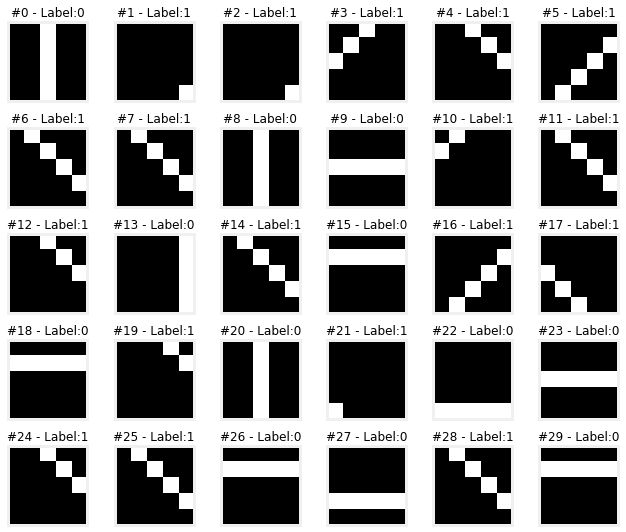

In [59]:
# let’s visualize the first 30 images
fig = plot_images(images, labels, n_plot=30)

###Images and Channels

To illustrate how images are represented, let’s create three separate images
first:

In [60]:
image_r = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

In [61]:
# If we perform a weighted average of these three colors, we’ll get another grayscale image.
image_gray = .2126*image_r + .7152*image_g + .0722*image_b

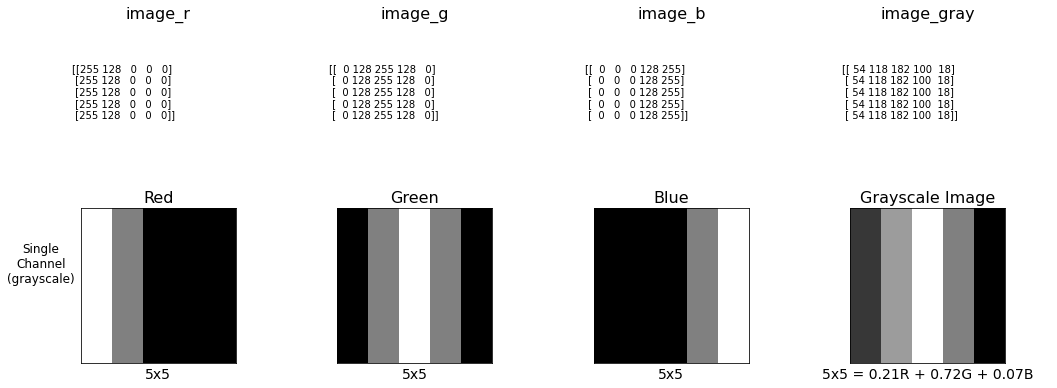

In [62]:
# Let’s see what the matrices above represent
fig = image_channels(image_r, image_g, image_b, None, image_gray, rows=(0, 1))

In [63]:
# we only need to stack the three images representing the three colors, each image becoming a channel
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

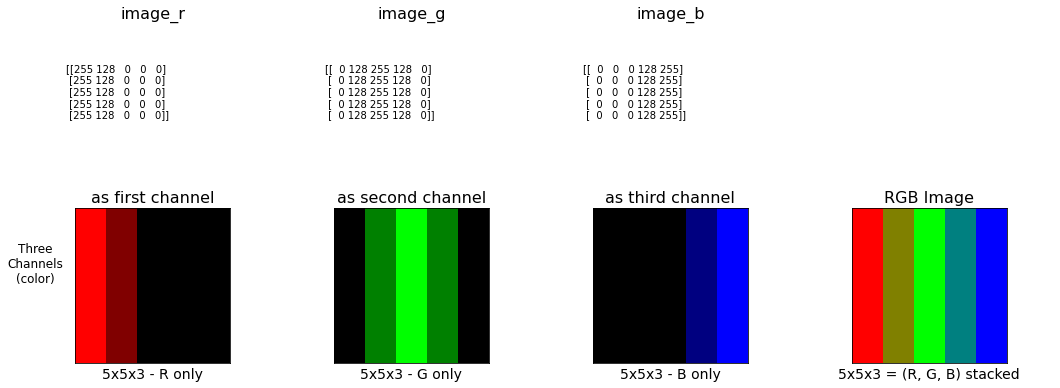

In [64]:
# Let’s see what those same matrices represent
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

###Image Shape

Our dataset generates images following the PyTorch format; that is, NCHW.

In [65]:
# What’s the shape of our dataset
images.shape

(300, 1, 5, 5)

In [66]:
# Let’s take a closer look at one image
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

What would an image in the HWC (PIL image format) look like?

We can transpose
the first dimension to become the last using Numpy's `transpose()`:

In [67]:
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape

(5, 5, 1)

In [68]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

##Torchvision

Torchvision is a package containing popular datasets, model architectures, and
common image transformations for computer vision.

* Datasets
* Models
* Transforms

###Image transformations

Let’s start by using `ToTensor()` to convert a Numpy array to a
PyTorch tensor.

In [69]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [70]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

<class 'PIL.Image.Image'>


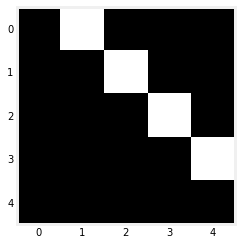

In [71]:
# let's visualize the resulting images
example_img = ToPILImage()(example_tensor)
print(type(example_img))

plt.imshow(example_img, cmap="gray")
plt.grid(False)

Torchvision implemented the interesting transformations that modify the training images in many different ways:

- rotating
- shifting
- flipping
- cropping,
- blurring
- zooming in
- adding noise
- erasing

That’s what’s called data augmentation. It is a clever technique to expand a
dataset (augment it) without collecting more data.

Let’s use our
example image above and try some random horizontal flipping.

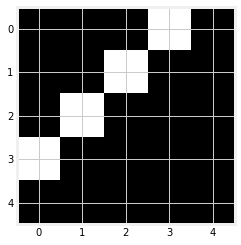

In [72]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

plt.imshow(flipped_img, cmap="gray")
plt.show()

###Transforms on Tensor

There are only four transforms that take (non-image) tensors as inputs:
- `LinearTransformation()`
- `Normalize()`
- `RandomErasing()`
- `ConvertImageDtype()`

First, let’s transform our flipped image to a tensor.

In [73]:
img_tensor = tensorizer(example_img)
img_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

Now we can apply one of the most common transformations: `Normalize()`.

But, instead of computing mean and standard deviation first,let’s set the mean to 0.5 and set the standard deviation to 0.5 as well.

By doing so, we’ll effectively be performing a min-max scaling such that the resulting range is `[-1, 1]`.

$$
\Large
\begin{aligned}
\text{input} = 0 \implies \frac{0 - \text{mean}}{\text{std}}= \frac{0 - 0.5}{0.5}&=-1
\\
\text{input} = 1 \implies \frac{1 - \text{mean}}{\text{std}}= \frac{1 - 0.5}{0.5}&=1
\end{aligned}
$$

Now, if we had taken the trouble of actually computing the real mean and
standard deviation of the training data, we would have achieved an actual
standardization; that is, our training data would have zero mean and unit standard
deviation.



In [74]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

tensor([[[-1.,  1., -1., -1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1., -1., -1.,  1., -1.],
         [-1., -1., -1., -1.,  1.],
         [-1., -1., -1., -1., -1.]]])

###Composing Transforms

When composing several transformations into a single, big,
composed transformation, we use `Compose()` function.

It is quite simple, actually: Just line up all desired transformations in a list. This
works pretty much the same way as a pipeline in Scikit-Learn.

Let’s compose a new transformation using the following list of transformations:

- First, let’s flip an image using `RandomHorizontalFlip()`.
- Next, let’s perform some min-max scaling using `Normalize()`.

In [75]:
composer = Compose([
  RandomHorizontalFlip(p=1.0),
  Normalize(mean=(.5,), std=(.5,))
])

composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(False)

In [76]:
# let’s briefly compare it to the example_tensor we used as the actual input
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


As you can see, the only differences between them are the scale (255 vs one) and
the type (integer and float).

We can convert the former into the latter using a one-liner.

In [77]:
example_tensor = torch.as_tensor(example / 255).float()
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

##Data Preparation

The first step of data preparation, is to convert our
features and labels from Numpy arrays to PyTorch tensors.

In [78]:
# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

###Dataset Transforms

Let's build our own custom dataset that is capable of handling
transformations.

In [79]:
class TransformedDataset(Dataset):
  def __init__(self, x, y, transform=None):
    self.x = x
    self.y = y
    self.transform = transform

  def __getitem__(self, index):
    x = self.x[index]

    # transforms the features
    if self.transform:
      x = self.transform(x)

    return x, self.y[index]

  def __len__(self):
    return len(self.x)

So, let’s redefine our composed transformations and create our dataset.

In [80]:
composer = Compose([
    RandomHorizontalFlip(p=0.5),
    Normalize(mean=(.5,), std=(.5,))
])

dataset = TransformedDataset(x_tensor, y_tensor, composer)

###Data sampler

The SubsetRandomSampler samples indices from a list, given as argument, without
replacement. As in the other samplers, these indices are used to load data from a
dataset. 

If an index is not on the list, the corresponding data point will never be
used.



In [81]:
def index_splitter(n, splits, seed=13):
  idx = torch.arange(n)
  # Makes the split argument a tensor
  splits_tensor = torch.as_tensor(splits)
  # Finds the correct multiplier, so we don't have to worry about summing up to N (or one)
  multiplier = n / splits_tensor.sum()
  splits_tensor = (multiplier * splits_tensor).long()
  # If there is a difference, throws at the first split so random_split does not complain
  diff = n - splits_tensor.sum()
  splits_tensor[0] += diff
  # Uses PyTorch random_split to split the indices
  torch.manual_seed(seed)
  return random_split(idx, splits_tensor)

In [82]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

In [83]:
train_idx.indices[:5]

[118, 170, 148, 239, 226]

Next, each Subset object is used as an argument to the corresponding sampler.

In [84]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

So, we can use a single dataset from which to load the data since the split is
controlled by the samplers. 

But we still need two data loaders, each using its
corresponding sampler.

In [85]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

>If you’re using a sampler, you cannot set `shuffle=True`.

We can also check if the loaders are returning the correct number of mini-batches.

In [86]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

OK, cool, this means we don’t need two (split) datasets anymore—we only need
two samplers.

###Data Augmentation

The reason why we may still need two split datasets
is exactly that: data augmentation. 

In general, we want to apply data augmentation
to the training data only.

Data augmentation is accomplished using composing
transforms, which will be applied to all points in the dataset.

If we need some data points to be augmented, the easiest way to
accomplish this is to create two composers and use them in two different datasets.

In [87]:
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

Then, here come the two composers: The `train_composer()` augments the data,
and then scales it (min-max); the `val_composer()` only scales the data (min-max).

In [88]:
train_composer = Compose([RandomHorizontalFlip(p=.5), Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

Next, we use them to create two datasets and their corresponding data loaders.

In [89]:
train_dataset = TransformedDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

###Weighted Data Sampler

Now, we can tackle the imbalance using a different
approach: A weighted sampler.

The reasoning is pretty much simple, we use
weights for sampling.

The class with fewer data points (minority class) should get larger weights, while the class with more data points (majority class) should get
smaller weights. This way, on average, we’ll end up with mini-batches containing
roughly the same number of data points in each class: A balanced dataset.

First, we need to find how imbalanced the dataset is.

In [90]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


Next, we compute the weights by inverting the counts.

In [91]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

The minority class should have the largest weight, so each data
point belonging to it gets overrepresented to compensate for the
imbalance.


Since there are 240 images in our training set, we need 240 weights.

In [92]:
sample_weights = weights[y_train_tensor.squeeze().long()]

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


Let’s create both the generator and
the sampler now.

In [93]:
# To ensure reproducibility, need to create and assign a generator to the sampler
generator = torch.Generator()

weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,  # A sequence of weights
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True     # draws samples with replacement
)

Now, let’s (re-)create the data loaders using the weighted sampler with the training set.

In [94]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

Let’s build yet another function to wrap it all up.

In [95]:
def make_balanced_sampler(y):
  # Computes weights for compensating imbalanced classes
  classes, counts = y.unique(return_counts=True)
  weights = 1.0 / counts.float()
  sample_weights = weights[y.squeeze().long()]
  # Builds sampler with compute weights
  generator = torch.Generator()
  weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,  # A sequence of weights
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True     # draws samples with replacement
  )
  return weighted_sampler

In [96]:
weighted_sampler = make_balanced_sampler(y_train_tensor)

Time to set the seed for the generator used in the sampler assigned to the data
loader.

In [97]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

Now we can check if our sampler is doing its job correctly.

In [98]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

Close enough! We have 160 images of the positive class, and now, thanks to the
weighted sampler, we’re sampling only 123 of them. 

It means we’re oversampling
the negative class (which has 80 images) to a total of 117 images, adding up to 240
images.

Mission accomplished, our dataset is balanced now.

It’s better to be safe than sorry, so we better set yet another seed to ensure the
reproducibility of our code.

Let’s update it to include more seeds.

In [99]:
def set_seed(self, seed=42):
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False    
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  try:
      self.train_loader.sampler.generator.manual_seed(seed)
  except AttributeError:
      pass

setattr(StepByStep, 'set_seed', set_seed)

###Putting It Together

We’ve gone through a lot of things regarding the data preparation step. 

Let’s put
them all together to get a better view of the big picture here.

In [100]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = x_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([
    RandomHorizontalFlip(p=.5),
    Normalize(mean=(.5,), std=(.5,))
])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
weighted_sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

###Pixels as Features

Let’s take one mini-batch of images from our training set to illustrate how it works.

In [101]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

Our dummy mini-batch has 16 images, one channel each, dimensions five-by-five
pixels. 

What if we flatten this mini-batch?

In [102]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


By default, it preserves the first dimension such that we keep the number of data
points in the mini-batch, but it collapses the remaining dimensions.

>Don’t we lose information when we flatten pixels?

Sure we do! And that’s why convolutional neural networks (CNNs) are so successful: They do not lose this information.


##Shallow Model

Logistic regression is a simple and shallow model.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/classification.png?raw=1)

Given 25 features, $x_0$ through $x_{24}$, each corresponding to the value of a pixel in a
given channel, the model will fit a linear regression such that its outputs are logits
(`z`), which are converted into probabilities using a sigmoid function.

The vectorized representations of the weights (`W`) and features (`X`) are:

$$
\Large W =
\underset{(25 \times 1)}{
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_{24}
\end{bmatrix}};
X = 
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
$$

The logits (`z`) are given by the following expression:

$$
\Large 
\begin{aligned}
z
& = W^T \cdot X 
=\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}} 
=
\underset{(1 \times 25)}{
\begin{bmatrix}
w_0 & w_1 & \cdots & w_{24}
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$

This is what the model configuration looks like for our classification problem:

In [110]:
torch.manual_seed(17)

# Sets learning rate
lr = 0.1

# Now we can create a model
logistic_model = nn.Sequential()
logistic_model.add_module('flatten', nn.Flatten())
logistic_model.add_module('output', nn.Linear(25, 1, bias=False))
logistic_model.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_logistic = optim.SGD(logistic_model.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

Let’s train our model for 100 epochs.

In [105]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [108]:
dummy_ys.shape

torch.Size([16, 1])

In [111]:
n_epochs = 100

sbs_logistic = StepByStep(logistic_model, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

ValueError: ignored